In [20]:
import cv2
import gfootball.env as football_env
import  gymnasium as gym
import numpy as np

import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor

from collections import deque

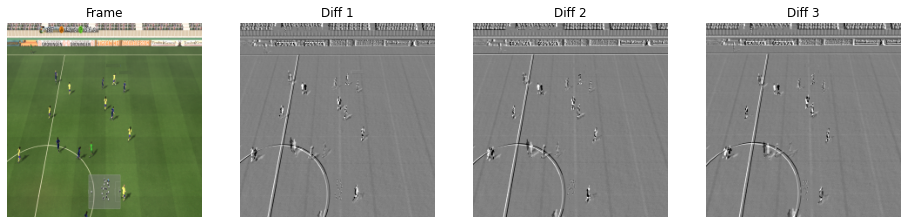

In [21]:
real_obs = np.load("../.scratch/frames_no_name_npy/frame_50.npy")

# Zobrazenie jednotlivých RGB snímok
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 riadok s 4 obrázkami
axes = axes.ravel()  # Získame zoznam axov pre každý obrázok

obs = np.squeeze(real_obs)
obs = np.transpose(obs, (1, 2, 0))

axes[0].imshow(obs[..., :3].astype(int))
axes[0].set_title("Frame")
axes[0].axis('off')  # Skryjeme osi

axes[1].imshow(obs[..., 3], cmap='gray')
axes[1].set_title("Diff 1")
axes[1].axis('off')  # Skryjeme osi

axes[2].imshow(obs[..., 4], cmap='gray')
axes[2].set_title("Diff 2")
axes[2].axis('off')  # Skryjeme osi

axes[3].imshow(obs[..., 5], cmap='gray')
axes[3].set_title("Diff 3")
axes[3].axis('off')  # Skryjeme osi

plt.show()

In [22]:
import numpy as np

# Načítanie dát zo súborov
gfootball_data = np.load('../.scratch/frames/episode_1/frame_0010.npy') 
real_video_data = np.load('../data/chance_frame.npy') 

# Zobrazenie tvaru dát
print(f"GFootball data shape: {gfootball_data.shape}")
print(f"Real video data shape: {real_video_data.shape}")


GFootball data shape: (224, 224, 6)
Real video data shape: (224, 224, 6)


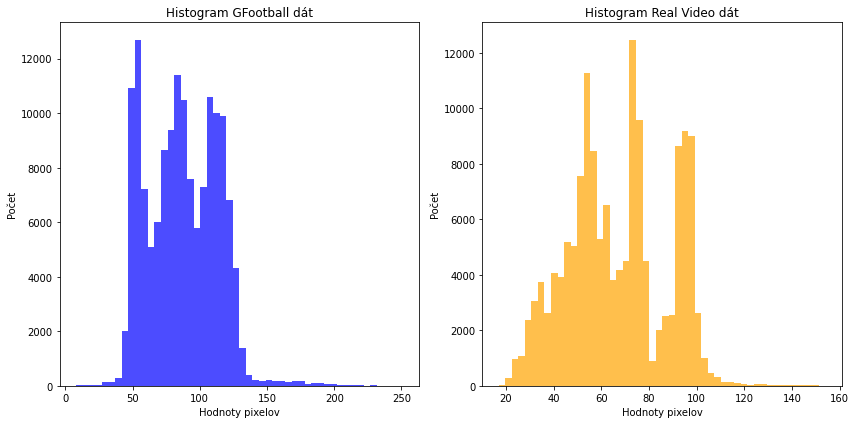

In [23]:
import matplotlib.pyplot as plt


# Vytvorenie histograma pre GFootball dáta
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(gfootball_data[..., :3].flatten(), bins=50, color='blue', alpha=0.7, label="GFootball")
plt.title("Histogram GFootball dát")
plt.xlabel("Hodnoty pixelov")
plt.ylabel("Počet")

# Vytvorenie histograma pre reálne dáta
plt.subplot(1, 2, 2)
plt.hist(real_video_data[..., :3].flatten(), bins=50, color='orange', alpha=0.7, label="Real Videos")
plt.title("Histogram Real Video dát")
plt.xlabel("Hodnoty pixelov")
plt.ylabel("Počet")

# Zobrazenie grafu
plt.tight_layout()
plt.show()


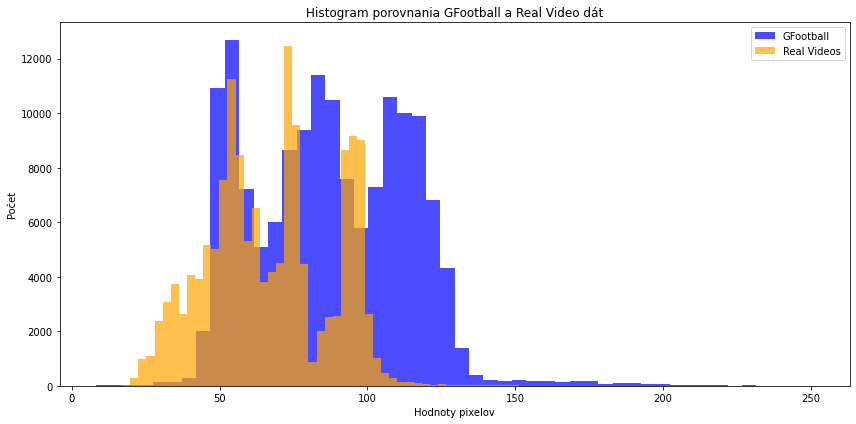

In [24]:
import matplotlib.pyplot as plt

# Vytvorenie histograma pre GFootball dáta a Real Video dáta na jednom grafe
plt.figure(figsize=(12, 6))

# Histogram pre GFootball dáta
plt.hist(gfootball_data[..., :3].flatten(), bins=50, color='blue', alpha=0.7, label="GFootball")

# Histogram pre Real Video dáta
plt.hist(real_video_data[..., :3].flatten(), bins=50, color='orange', alpha=0.7, label="Real Videos")

# Titulky a popisky
plt.title("Histogram porovnania GFootball a Real Video dát")
plt.xlabel("Hodnoty pixelov")
plt.ylabel("Počet")
plt.legend()

# Zobrazenie grafu
plt.tight_layout()
plt.show()


In [25]:
# Výpočet priemeru a smerodajnej odchýlky pre GFootball a reálne dáta
mean_gfootball = np.mean(gfootball_data)
std_gfootball = np.std(gfootball_data)

mean_real_video = np.mean(real_video_data)
std_real_video = np.std(real_video_data)

print(f"GFootball mean: {mean_gfootball}, std: {std_gfootball}")
print(f"Real video mean: {mean_real_video}, std: {std_real_video}")


GFootball mean: 107.60197106186224, std: 28.09168257528589
Real video mean: 97.52608489990234, std: 33.91816711425781


In [26]:
from sklearn.metrics import mean_squared_error

# Predpokladajme, že máš obrázky v rovnakom formáte (napr. 3D numpy pole: [výška, šírka, kanály])
mse = mean_squared_error(gfootball_data.flatten(), real_video_data.flatten())
print(f"Mean Squared Error medzi gfootball a reálnymi dátami: {mse}")


Mean Squared Error medzi gfootball a reálnymi dátami: 717.3350219726562


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# Predpokladajme, že máme obrázky v jednom rozmere (napr. [batch_size, výška, šírka, kanály])
cos_sim = cosine_similarity(gfootball_data.reshape(-1, gfootball_data.shape[-1]), real_video_data.reshape(-1, real_video_data.shape[-1]))
print(f"Cosine Similarity: {cos_sim}")

Cosine Similarity: [[0.89021488 0.8891535  0.88771574 ... 0.98408415 0.98498198 0.98498198]
 [0.89097358 0.88992231 0.88848061 ... 0.98445944 0.98534408 0.98534408]
 [0.89133918 0.89031147 0.8888433  ... 0.98428592 0.98516617 0.98516617]
 ...
 [0.9329342  0.93210063 0.93084963 ... 0.99183343 0.99199342 0.99199342]
 [0.93791258 0.93711609 0.9358972  ... 0.9921509  0.99223168 0.99223168]
 [0.9391582  0.93834281 0.93715251 ... 0.99169934 0.99175363 0.99175363]]


In [28]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import itertools

def simulate_style_transform(frame, sat=1.0, val=1.0, contrast=1.0, blur=0, noise_std=0.0):
    # HSV úprava (saturation, value)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 1] *= sat
    hsv[..., 2] *= val
    hsv = np.clip(hsv, 0, 255).astype(np.uint8)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR).astype(np.float32)

    # Kontrast
    bgr = cv2.convertScaleAbs(bgr, alpha=contrast, beta=0).astype(np.float32)

    # Blur
    if blur > 0:
        k = blur if blur % 2 == 1 else blur + 1  # kernel musí byť nepárny
        bgr = cv2.GaussianBlur(bgr, (k, k), 0)

    # Šum
    if noise_std > 0:
        noise = np.random.normal(0, noise_std * 255, bgr.shape)
        bgr += noise
        bgr = np.clip(bgr, 0, 255)

    return bgr.astype(np.uint8)

def compare_to_sim(real_frame, sim_frame, **params):
    aug = simulate_style_transform(real_frame, **params)
    gray_aug = cv2.cvtColor(aug, cv2.COLOR_BGR2GRAY)
    gray_sim = cv2.cvtColor(sim_frame, cv2.COLOR_BGR2GRAY)

    if gray_aug.shape != gray_sim.shape:
        gray_sim = cv2.resize(gray_sim, (gray_aug.shape[1], gray_aug.shape[0]))
    
    return ssim(gray_aug, gray_sim)

def find_best_augmentation(real_frame, sim_frame):
    sat_vals = [0.6, 0.7]
    val_vals = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
    contrast_vals = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
    blur_vals = [ 0, 1, 2, 3, 4, 5]          # 0 = žiadny blur
    noise_vals = [0.0, 0.01, 0.02] # std dev

    best_score = -1
    best_params = None

    combos = list(itertools.product(sat_vals, val_vals, contrast_vals, blur_vals, noise_vals))
    print(f"🔍 Testujem {len(combos)} kombinácií...")

    for sat, val, contrast, blur, noise in combos:
        params = {
            "sat": sat,
            "val": val,
            "contrast": contrast,
            "blur": blur,
            "noise_std": noise
        }
        score = compare_to_sim(real_frame, sim_frame, **params)
        print(f"sat={sat:.2f}, val={val:.2f}, contrast={contrast:.2f}, blur={blur}, noise={noise:.2f} -> SSIM={score:.4f}")
        if score > best_score:
            best_score = score
            best_params = params.copy()

    print("\n✅ Najlepšia kombinácia:")
    print(f"{best_params}, SSIM = {best_score:.4f}")
    return best_params, best_score


In [29]:
gfootball_data = np.load('../.scratch/frames/episode_1/frame_0010.npy') 
real_video_data = np.load('../data/chance_frame.npy') 

# Vyber len prvé tri kanály (ak sú v poradí BGR)
real_rgb = real_video_data[..., :3].astype(np.uint8)
sim_rgb = gfootball_data[..., :3].astype(np.uint8)

# Zavolaj funkciu na hľadanie najlepšej augmentácie
best_params, best_score = find_best_augmentation(real_rgb, sim_rgb)

🔍 Testujem 1764 kombinácií...
sat=0.60, val=0.60, contrast=0.60, blur=0, noise=0.00 -> SSIM=0.4114
sat=0.60, val=0.60, contrast=0.60, blur=0, noise=0.01 -> SSIM=0.3885
sat=0.60, val=0.60, contrast=0.60, blur=0, noise=0.02 -> SSIM=0.3468
sat=0.60, val=0.60, contrast=0.60, blur=1, noise=0.00 -> SSIM=0.4114
sat=0.60, val=0.60, contrast=0.60, blur=1, noise=0.01 -> SSIM=0.3891
sat=0.60, val=0.60, contrast=0.60, blur=1, noise=0.02 -> SSIM=0.3461
sat=0.60, val=0.60, contrast=0.60, blur=2, noise=0.00 -> SSIM=0.4103
sat=0.60, val=0.60, contrast=0.60, blur=2, noise=0.01 -> SSIM=0.3910
sat=0.60, val=0.60, contrast=0.60, blur=2, noise=0.02 -> SSIM=0.3478
sat=0.60, val=0.60, contrast=0.60, blur=3, noise=0.00 -> SSIM=0.4103
sat=0.60, val=0.60, contrast=0.60, blur=3, noise=0.01 -> SSIM=0.3909
sat=0.60, val=0.60, contrast=0.60, blur=3, noise=0.02 -> SSIM=0.3492
sat=0.60, val=0.60, contrast=0.60, blur=4, noise=0.00 -> SSIM=0.4112
sat=0.60, val=0.60, contrast=0.60, blur=4, noise=0.01 -> SSIM=0.3929
sat=

sat=0.60, val=0.60, contrast=0.70, blur=5, noise=0.02 -> SSIM=0.3923
sat=0.60, val=0.60, contrast=0.80, blur=0, noise=0.00 -> SSIM=0.5012
sat=0.60, val=0.60, contrast=0.80, blur=0, noise=0.01 -> SSIM=0.4751
sat=0.60, val=0.60, contrast=0.80, blur=0, noise=0.02 -> SSIM=0.4245
sat=0.60, val=0.60, contrast=0.80, blur=1, noise=0.00 -> SSIM=0.5012
sat=0.60, val=0.60, contrast=0.80, blur=1, noise=0.01 -> SSIM=0.4753
sat=0.60, val=0.60, contrast=0.80, blur=1, noise=0.02 -> SSIM=0.4231
sat=0.60, val=0.60, contrast=0.80, blur=2, noise=0.00 -> SSIM=0.5030
sat=0.60, val=0.60, contrast=0.80, blur=2, noise=0.01 -> SSIM=0.4796
sat=0.60, val=0.60, contrast=0.80, blur=2, noise=0.02 -> SSIM=0.4271
sat=0.60, val=0.60, contrast=0.80, blur=3, noise=0.00 -> SSIM=0.5030
sat=0.60, val=0.60, contrast=0.80, blur=3, noise=0.01 -> SSIM=0.4799
sat=0.60, val=0.60, contrast=0.80, blur=3, noise=0.02 -> SSIM=0.4267
sat=0.60, val=0.60, contrast=0.80, blur=4, noise=0.00 -> SSIM=0.5055
sat=0.60, val=0.60, contrast=0.80,